Student Name: Ahmad Rashidh Ameer Hamsha
Student ID: 23264306

   # GA applied to OneMax

This notebook implements a simple GA in a fairly lowlevel way. In later examples we'll use more highlevel operators, but it is a very valuable exercise to ensure you understand what this code is actually doing. Make sure you understand the processes below before moving to the more high-level toolboxes!

Install DEAP. Note that if you are running this on your own computer you might not need to do this. In fact, it is better practice to install it so that it is always available, but when running on Colab, we do need this.

In [1]:
!pip install deap

Import the DEAP tools and useful libraries (random and matplotlib).

In [2]:
from deap import base
from deap import creator
from deap import tools

import random

import matplotlib.pyplot as plt

1. Set any problem-specific constants here. In this case we need to know how long the string is.
2. Set the random seed. This is important so that we can reproduce runs later on.
3. Set GA Operators

In [21]:
NO_ITEMS = 100
MAX_WEIGHT = 1000

# set the random seed. Make sure you do this BEFORE creating the knapsack
# creating the knapsack
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Set Genetic Algorithm constants:
POPULATION_SIZE = 500
P_CROSSOVER = 0.7  # probability for crossover
P_MUTATION = 0.01   # probability for mutating an individual
MAX_GENERATIONS = 300
SEL_TOURNSIZE = 3

# Create the item dictionary: item name is an integer, and value is
# a (value, weight) 2-uple.
items = {}

# Create random items and store them in the items' dictionary.
for i in range(NO_ITEMS):
     items[i] = (random.randint(1, 10), random.randint(1, 100))

Create our toolbox. Note that we can pull in a bunch of predefined operators to tailor our Evolutionary Algorithm, which, of course, in this case is a GA. Notice that it is possible to create our **own** operators and functions to use, which is what we do with our **oneMaxFitness** function below.

In [5]:
toolbox = base.Toolbox()

# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMax)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, NO_ITEMS)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [25]:


# Fitness calculation: compute the weight of the individual, penalty the exceeding weight from total value
def max_fitness(individual):
  total_value = 0
  total_weight = 0
  for i, (k,v) in enumerate(items.items()):
    if individual[i] == 1:
      total_value += v[0]
      total_weight += v[1]

  # Penalize solutions that exceed the weight limit
  penalty = max(0, total_weight - MAX_WEIGHT)
  fitness = total_value - penalty
  return (fitness,)


toolbox.register("evaluate", max_fitness)

# Single-point crossover:
toolbox.register("mate", tools.cxOnePoint)

# Flip-bit mutation:
# indpb: Independent probability for each attribute to be flipped
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/NO_ITEMS)


In [26]:
# Having this function to modify values
def set_tournsize(size):
  toolbox.register("select", tools.selTournament, tournsize=SEL_TOURNSIZE)

Here is the main GA loop. We will iterate through it up to the MAX_GENERATIONS parameter and then print out our best individual.

In [27]:
def plotStatistics(max, mean):
  plt.plot(max, color='red')
  plt.plot(mean, color='green')
  plt.xlabel('Generation')
  plt.ylabel('Max / Average Fitness')
  plt.title('Max and Average Fitness over Generations')
  plt.show()

In [28]:
def main(tournsize = SEL_TOURNSIZE, p_cross = P_CROSSOVER, p_mutate = P_MUTATION, pop_size=500, max_weight = MAX_WEIGHT, generation_counter = MAX_GENERATIONS ):

  set_tournsize(tournsize)

  # create initial population (generation 0):
  population = toolbox.populationCreator(n=pop_size)
  generationCounter = 0

  # calculate fitness tuple for each individual in the population:
  fitnessValues = list(map(toolbox.evaluate, population))
  for individual, fitnessValue in zip(population, fitnessValues):
      individual.fitness.values = fitnessValue

  # extract fitness values from all individuals in population:
  fitnessValues = [individual.fitness.values[0] for individual in population]

  # initialize statistics accumulators:
  maxFitnessValues = []
  meanFitnessValues = []

  # main evolutionary loop:
  # stop if max fitness value reached the known max value
  # OR if number of generations exceeded the preset value:
  while max(fitnessValues) < MAX_WEIGHT and generationCounter < generation_counter:
      # update counter:
      generationCounter = generationCounter + 1

      # apply the selection operator, to select the next generation's individuals:
      offspring = toolbox.select(population, len(population))

      # clone the selected individuals:
      offspring = list(map(toolbox.clone, offspring))

      # apply the crossover operator to pairs of offspring:
      for child1, child2 in zip(offspring[::2], offspring[1::2]):
          if random.random() < p_cross:
              toolbox.mate(child1, child2)
              del child1.fitness.values
              del child2.fitness.values

      for mutant in offspring:
          if random.random() < p_mutate:
              toolbox.mutate(mutant)
              del mutant.fitness.values

      # calculate fitness for the individuals with no previous calculated fitness value:
      freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
      freshFitnessValues = list(map(toolbox.evaluate, freshIndividuals))
      for individual, fitnessValue in zip(freshIndividuals, freshFitnessValues):
          individual.fitness.values = fitnessValue

      # replace the current population with the offspring:
      population[:] = offspring

      # collect fitnessValues into a list, update statistics and print:
      fitnessValues = [ind.fitness.values[0] for ind in population]

      maxFitness = max(fitnessValues)
      meanFitness = sum(fitnessValues) / len(population)
      maxFitnessValues.append(maxFitness)
      meanFitnessValues.append(meanFitness)
      print("- Generation {}: Max Fitness = {}, Avg Fitness = {}".format(generationCounter, maxFitness, meanFitness))

      # find and print best individual:
      best_index = fitnessValues.index(max(fitnessValues))
      print("Best Individual = ", *population[best_index], "\n")

  print("Weight of the best individual = ", max_fitness(population[best_index]))
  plotStatistics(maxFitnessValues, meanFitnessValues)

- Generation 1: Max Fitness = -431.0, Avg Fitness = -1114.392
Best Individual =  0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 0 1 

- Generation 2: Max Fitness = -156.0, Avg Fitness = -897.772
Best Individual =  1 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 

- Generation 3: Max Fitness = -81.0, Avg Fitness = -733.898
Best Individual =  1 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 

- Generation 4: Max Fitness = 15.0, Avg Fitness = -574.154
Best Individual =  0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 

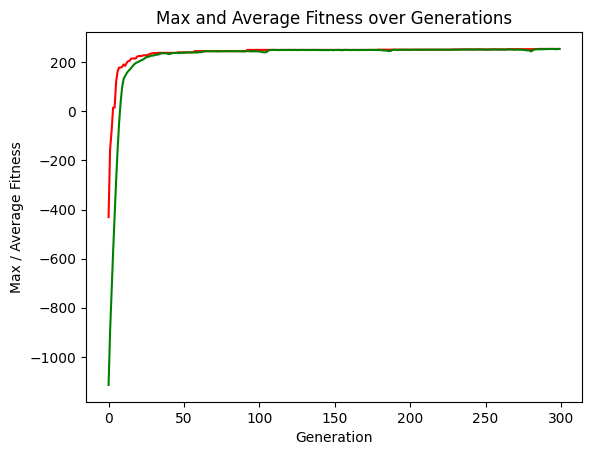

In [29]:
main()

- Generation 1: Max Fitness = -418.0, Avg Fitness = -1101.684
Best Individual =  0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 

- Generation 2: Max Fitness = -418.0, Avg Fitness = -905.75
Best Individual =  0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 

- Generation 3: Max Fitness = -105.0, Avg Fitness = -750.896
Best Individual =  1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 

- Generation 4: Max Fitness = -105.0, Avg Fitness = -608.384
Best Individual =  1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 

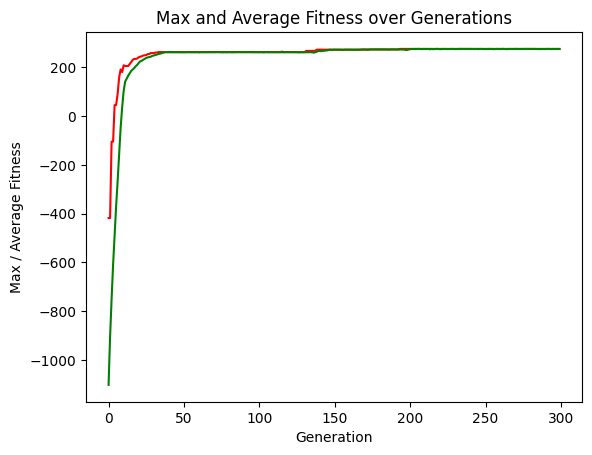

In [30]:
main(tournsize = 5)